In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from datetime import datetime
import matplotlib.dates as mdates

def string_to_int(n):
    if type(n) is not str:
        return int(n)
    return int(n.replace(',', ''))

df = pd.read_csv('daily-website-visitors.csv', converters={'Page.Loads': string_to_int,
                                                          'Unique.Visits': string_to_int,
                                                          'First.Time.Visits': string_to_int,
                                                          'Returning.Visits': string_to_int})
df.pop('Day')
df.pop('Row')
df.pop('Day.Of.Week')

date_time = pd.to_datetime(df['Date'], format='%m/%d/%Y')
dates = pd.to_datetime(df.pop('Date'), format='%m/%d/%Y')

timestamp_s = date_time.map(datetime.timestamp)
day = 24*60*60
weekday = 24*60*60*7
year = (365.2425)*day

df['Weekday sin'] = np.sin(timestamp_s * (2 * np.pi / weekday))
df['Weekday cos'] = np.cos(timestamp_s * (2 * np.pi / weekday))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

labels = np.array(df['Page.Loads'])

train_data = pd.concat([train_df, val_df])['Page.Loads']
test_data = test_df['Page.Loads']

method_to_predictions = {}

def print_metrics(method, preds, trim_head=None):
    if trim_head is not None:
        test_d = test_data[trim_head:]
    else:
        test_d = test_data
    print(method)
    print("R2 score:", r2_score(test_d, preds))
    print('Mean squared error:', mean_squared_error(test_d, preds))
    print('Mean absolute error:', mean_absolute_error(test_d, preds))
    
def plot_loss_scatter(preds, trim_head=None):
    if trim_head is not None:
        test_d = test_data[trim_head:]
    else:
        test_d = test_data
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.scatter(test_d, preds)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    lims = np.array([-2.5, 2.5])
    ax.plot(lims, lims)
    
def plot_real_vs_prediction(method, preds, trim_head=None):
    if trim_head is not None:
        test_d = test_data[trim_head:]
    else:
        test_d = test_data
    test_range = np.arange(len(test_d))
    fig, ax = plt.subplots()
    ax.set_title(method)
    ax.plot(test_range, test_d,  color='black', linewidth=3)
    ax.plot(test_range, preds, color='blue')
    ax.legend(['Actual value', 'Prediction'])

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='Page.Loads', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Days')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [3]:
result = adfuller(df['Page.Loads'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.283821
p-value: 0.000474
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


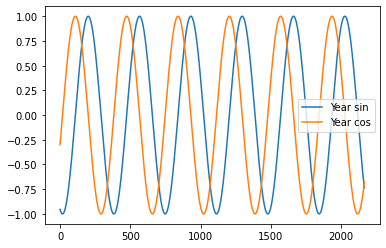

In [4]:
plt.plot(df['Year sin'])
plt.plot(df['Year cos'])
plt.legend(['Year sin', 'Year cos'])

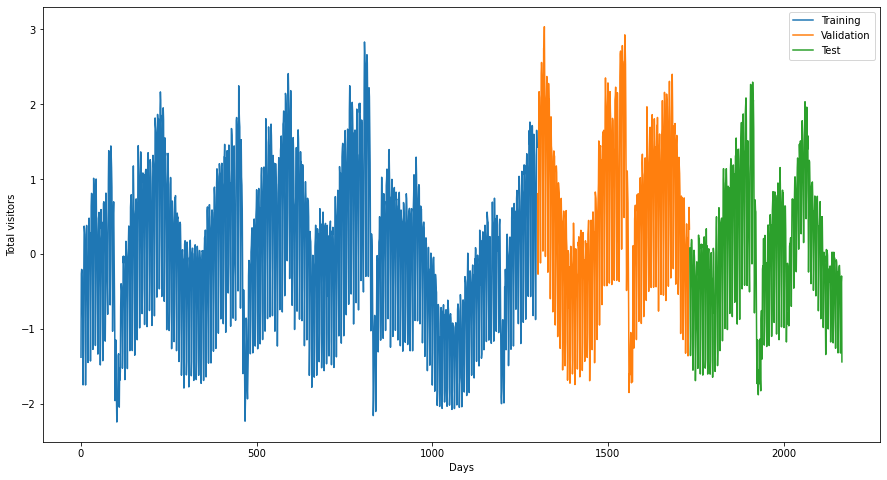

In [5]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train_df['Page.Loads'])
ax.plot(val_df['Page.Loads'])
ax.plot(test_df['Page.Loads'])
ax.set_xlabel('Days')
ax.set_ylabel('Total visitors')
ax.legend(['Training', 'Validation', 'Test'])

Mean
R2 score: -0.004274056027933515
Mean squared error: 0.8046451681152599
Mean absolute error: 0.7196929608249133


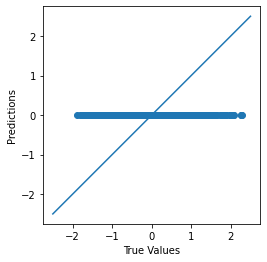

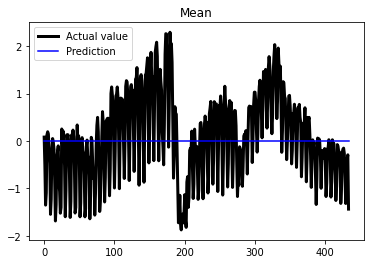

In [6]:
y_pred = np.zeros(test_data.shape)
y_pred.fill(train_df.mean()['Page.Loads']) 

print_metrics('Mean', y_pred)
plot_loss_scatter(y_pred)
plot_real_vs_prediction('Mean', y_pred)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

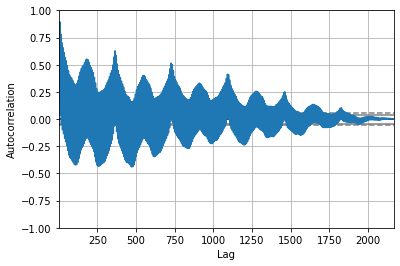

In [7]:
autocorrelation_plot(df['Page.Loads'])

Autoregression
R2 score: 0.6130860008429291
Mean squared error: 0.31000350753781636
Mean absolute error: 0.43778695368940235


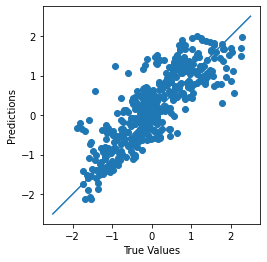

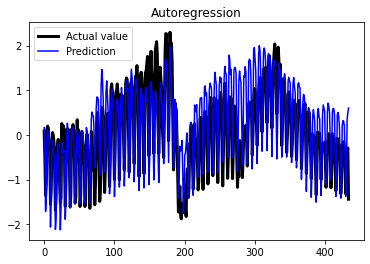

In [8]:
auto_reg_train = pd.concat([train_df, val_df])['Page.Loads']
auto_reg = AutoReg(auto_reg_train, lags=365, old_names=False, trend='t')
y_pred = auto_reg.fit().predict(len(auto_reg_train), len(auto_reg_train) + len(test_df) - 1)
method_to_predictions['AR'] = y_pred

print_metrics('Autoregression', y_pred)
plot_loss_scatter(y_pred)
plot_real_vs_prediction('Autoregression', y_pred)

Dense network
R2 score: 0.8938866251596753
Mean squared error: 0.0854070371904837
Mean absolute error: 0.22092335158781343


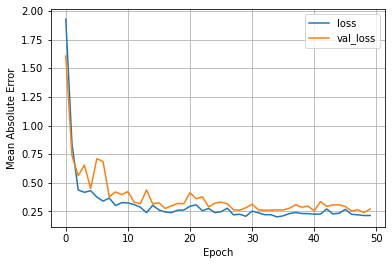

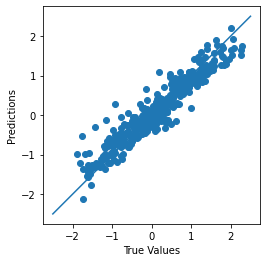

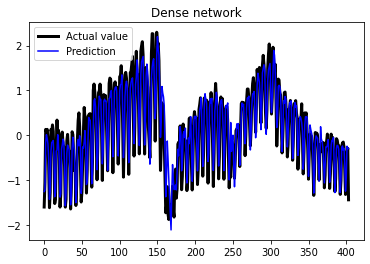

In [9]:
model = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(units=256),
    layers.Dense(units=128),
    layers.Dense(units=64),
    layers.Dense(units=32),
    layers.Dense(units=1)
])

WINDOW_WIDTH = 30

model.compile(
    optimizer='Adam',
    loss='mae')

wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, label_width=1, shift=1,
    label_columns=['Page.Loads'])

history = model.fit(
    wide_window.train,
    validation_data=wide_window.val,
    verbose=0,
    epochs=50)

def plot_loss(history):
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Absolute Error')
    ax.legend()
    ax.grid(True)

test_predictions = model.predict(wide_window.test)
method_to_predictions['Dense'] = test_predictions

print_metrics('Dense network', test_predictions, WINDOW_WIDTH)
plot_loss(history)
plot_loss_scatter(test_predictions, WINDOW_WIDTH)
plot_real_vs_prediction('Dense network', test_predictions, WINDOW_WIDTH)

Maximum similarity sample
R2 score: 0.4750670727069094
Mean squared error: 0.4205871305702992
Mean absolute error: 0.5080810529929842


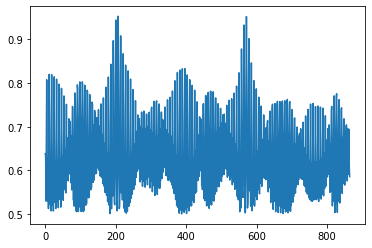

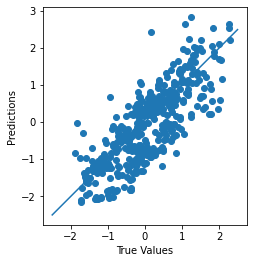

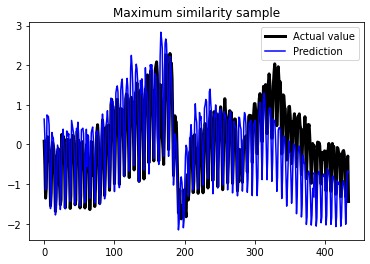

In [10]:
# Maximum similarity sample
sample_len = len(test_data)
likeness = []
mss_train_data = np.array(train_data)[..., None]

old_history = mss_train_data[:-sample_len].T
new_history = mss_train_data[-sample_len:].T

for index in range(len(old_history.T) - sample_len):
    sample = old_history[:, index:index+sample_len]
    likeness.append(np.mean(np.abs(np.corrcoef(sample, new_history))))

likeness = np.array(likeness)
max_likeness = np.max(likeness)
MSP_start = np.where(likeness == max_likeness)[0][0] + sample_len

y_pred = old_history[:, MSP_start:MSP_start+sample_len].T

plt.plot(likeness)
print_metrics('Maximum similarity sample', y_pred)
plot_loss_scatter(y_pred)
plot_real_vs_prediction('Maximum similarity sample', y_pred)

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


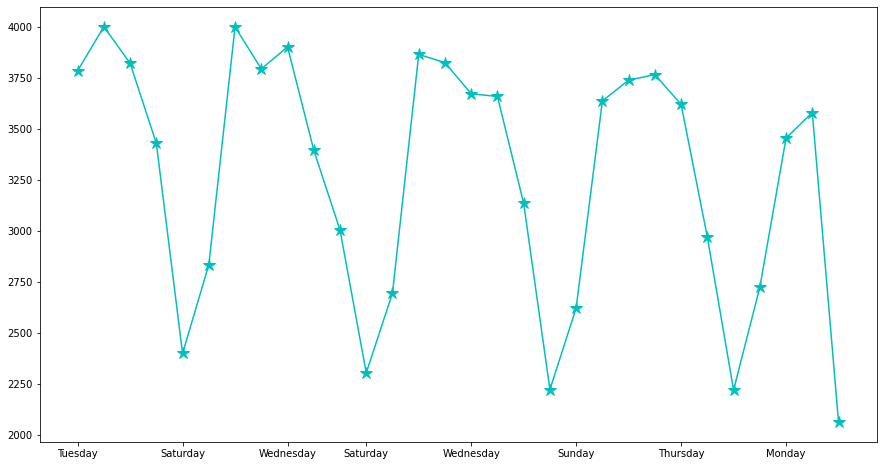

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
locator = mdates.AutoDateLocator()
formatter = mdates.DateFormatter('%A')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(dates[-30:], labels[-30:], marker='*', markersize=12, color='c')

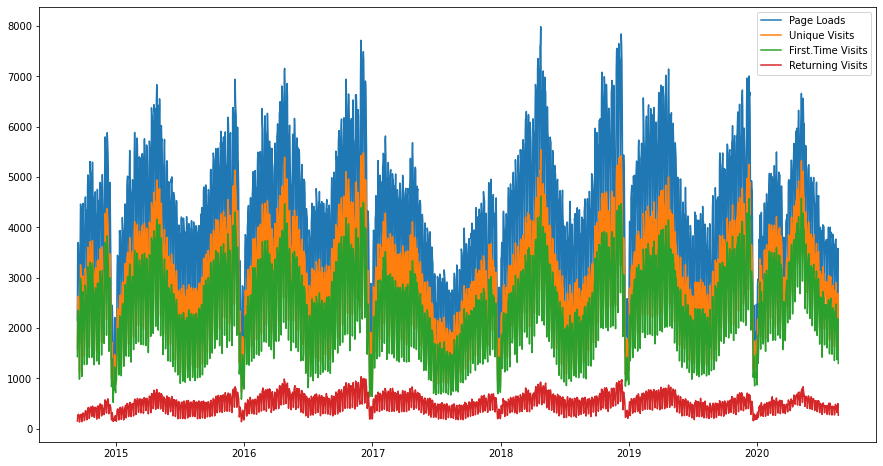

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(dates, df['Page.Loads'])
ax.plot(dates, df['Unique.Visits'])
ax.plot(dates, df['First.Time.Visits'])
ax.plot(dates, df['Returning.Visits'])
ax.legend(['Page Loads', 'Unique Visits', 'First.Time Visits', 'Returning Visits'])

SimpleRNN
R2 score: 0.8951021491730462
Mean squared error: 0.08442870335865414
Mean absolute error: 0.2157546336461326


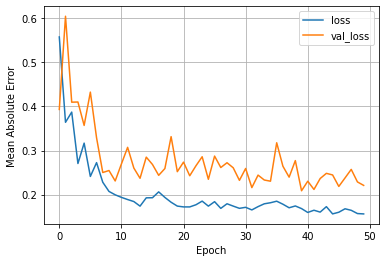

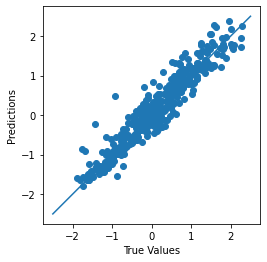

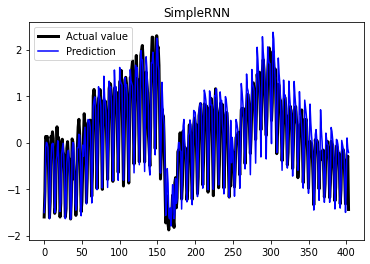

In [14]:
WINDOW_WIDTH = 30

wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, label_width=1, shift=1,
    label_columns=['Page.Loads'])

model = tf.keras.Sequential([
    layers.LSTM(1024),
    layers.Dense(1024),
    layers.Dense(units=1)
])

model.compile(
    optimizer='Adam',
    loss='mae')

history = model.fit(
    wide_window.train,
    validation_data=wide_window.val,
    epochs=50,
    verbose=0)

test_predictions = model.predict(wide_window.test)
method_to_predictions['RNN'] = test_predictions

print_metrics('SimpleRNN', test_predictions, WINDOW_WIDTH)
plot_loss(history)
plot_loss_scatter(test_predictions, WINDOW_WIDTH)
plot_real_vs_prediction('SimpleRNN', test_predictions, WINDOW_WIDTH)

In [15]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

print(len(test_predictions))

404


In [16]:
df.describe()

,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Weekday sin,Weekday cos,Year sin,Year cos
count,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,4116.989386,2943.646516,2431.824181,511.822335,-0.000733,-0.000733,0.009918,0.005563
std,1350.977843,977.886472,828.704688,168.736370,0.707270,0.707270,0.705278,0.709166
min,1002.000000,667.000000,522.000000,133.000000,-0.955573,-0.943883,-1.000000,-0.999999
25%,3114.500000,2226.000000,1830.000000,388.500000,-0.826239,-0.846724,-0.688108,-0.713392
50%,4106.000000,2914.000000,2400.000000,509.000000,-0.111964,-0.111964,0.017274,0.018245
75%,5020.500000,3667.500000,3038.000000,626.500000,0.707107,0.680173,0.712362,0.713572
max,7984.000000,5541.000000,4616.000000,1036.000000,0.993712,0.997204,0.999999,1.000000


Last value
R2 score: 0.5130937496299759
Mean squared error: 0.39011936964192717
Mean absolute error: 0.4984601008688646


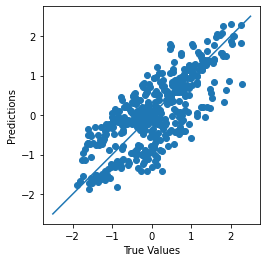

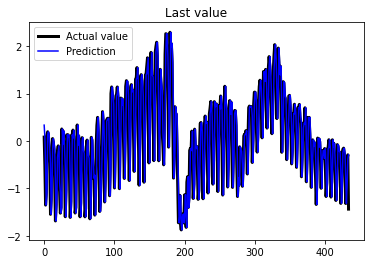

In [17]:
test_predictions = pd.concat([train_df, val_df, test_df])[int(n*0.8) - 1:-1]['Page.Loads']
method_to_predictions['Last value'] = test_predictions 

print_metrics('Last value', test_predictions)
plot_loss_scatter(test_predictions)
plot_real_vs_prediction('Last value', test_predictions)

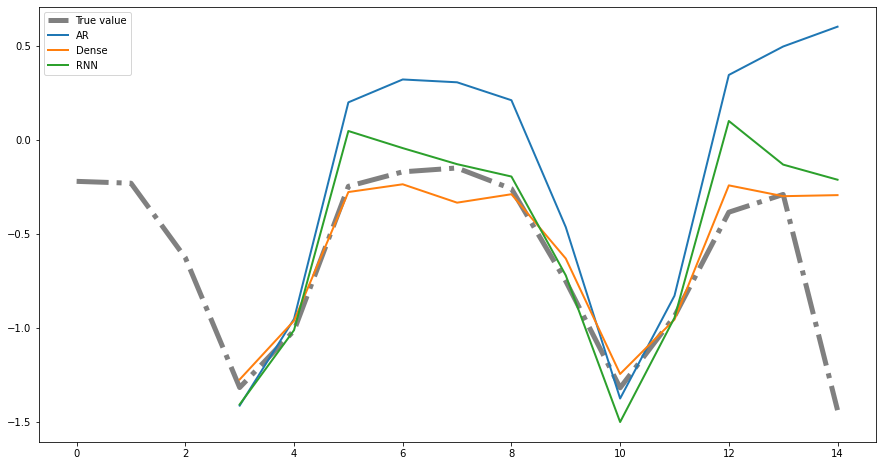

In [18]:
fig, ax = plt.subplots(figsize=(15,8))

TAIL_LENGTH = 12
TRUE_LENGTH = 15

true_plot_range = range(TRUE_LENGTH)
plot_range = range(TRUE_LENGTH - TAIL_LENGTH, TRUE_LENGTH)

ax.plot(true_plot_range, test_df['Page.Loads'][-TRUE_LENGTH:], lw=5, ls='-.', color='gray')
ax.plot(plot_range, method_to_predictions['AR'][-TAIL_LENGTH:], lw=2)
ax.plot(plot_range, method_to_predictions['Dense'][-TAIL_LENGTH:], lw=2)
ax.plot(plot_range, method_to_predictions['RNN'][-TAIL_LENGTH:], lw=2)

ax.legend(['True value', 'AR', 'Dense', 'RNN'])

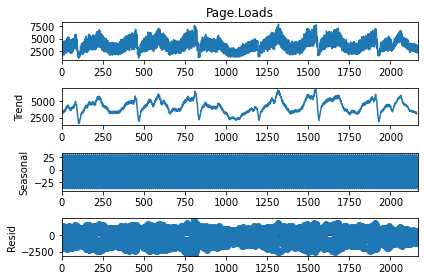

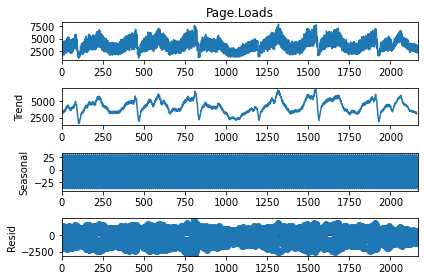

In [19]:
result = seasonal_decompose(df['Page.Loads'], model='additive', period=12)
result.plot()

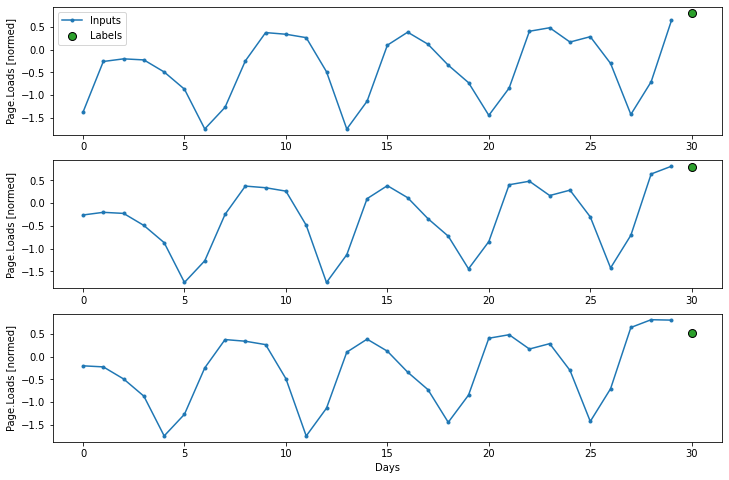

In [20]:
wide_window.plot()